# Outlier Detection
## Three methods (Gaussian Distribution, Local Outlier Factor, and Isolation Trees) are used to detect outliers in one of the two datasets.

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.neighbors import NearestNeighbors
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd

## Data 1

In [52]:
with open('/Users/wushuangyan/Projects/data_1.npy', 'rb') as f: 
    data1 = np.load(f)

pd.DataFrame(data1)

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,5.000719,5.274754,5.249499,4.614735,5.413515,3.980793,6.001460,3.598920,5.233456,4.217037,...,4.288981,4.319531,3.189518,3.980064,4.177364,5.776013,4.926472,-2.0,-2.0,10.0
1,0.892561,0.043747,-0.178435,-0.207742,1.029972,-0.035645,1.303102,0.493643,1.735314,2.761369,...,1.442224,0.821059,1.173238,1.838347,1.057674,2.890069,1.180025,2.0,-4.0,7.0


## Data 2

In [57]:
with open('/Users/wushuangyan/Desktop/STAT classes/Linear models/data_2.npy', 'rb') as f:
    data2 = np.load(f)
    
pd.DataFrame(data2)

,0,1
0,-2.000000,-3.000000
1,-1.000000,-2.000000
2,1.000000,2.000000
3,2.000000,1.000000
4,1.878490,1.974773
...,...,...
195,-1.824793,-1.840977
196,-2.078311,-2.225230
197,-1.647797,-1.799888
198,-2.423989,-1.618368


## Data 1 - Statistical Method - Gaussian Distribution

In [56]:
with open('/Users/wushuangyan/Desktop/STAT classes/Data Science/HW3/data_1.npy', 'rb') as f: 
    X = np.load(f)

print("Data Dimension:")
X.shape

X = X.T
x_mean = X.mean(axis = 0)
x_cov = np.cov(X.T, bias = True)
# k: X dimension
k = X.shape[0] 

p = np.zeros((X.shape[0], 2), dtype = float)

for i in np.arange(X.shape[0]):
    sample = X[i,:]
    p[i,:] += [i, ((2 * np.pi) ** (-(k/2))) * ((np.linalg.det(x_cov)) ** (-(1/2))) *
               (np.exp((-1/2) * ((sample - x_mean).T) @ (np.linalg.inv(x_cov)) @ (sample - x_mean)))]
    
p_sort = p[p[:, 1].argsort()]
print("Sample index and probability (p) in an increasing p order: ")
p_sort


ind = p_sort[0:3,0].astype(int)
print ("The indexes of the 3 samples with the lowest p:")
ind

print ("X of the 3 samples with low p:")
X[ind,:] 

Data Dimension:


(2, 600)

Sample index and probability (p) in an increasing p order: 


array([[5.97000000e+002, 1.21379850e-251],
       [5.98000000e+002, 2.92124212e-249],
       [5.99000000e+002, 1.88817113e-246],
       ...,
       [5.43000000e+002, 2.38837701e-240],
       [5.19000000e+002, 2.39621755e-240],
       [1.13000000e+002, 2.39805777e-240]])

The indexes of the 3 samples with the lowest p:


array([597, 598, 599])

X of the 3 samples with low p:


array([[-2.,  2.],
       [-2., -4.],
       [10.,  7.]])

## Data 1 - Local Outlier Factor (LOF)

In [61]:
class LocalOutlierFactor(object):
    def __init__(self, MinPts, data):
        self.MinPts = MinPts 
        self.data = data
        self.NumPoint = data.shape[0] 

        # compute k-distance and build k-distance neighborhood
        self.nbrs = NearestNeighbors(n_neighbors=self.MinPts)
        self.nbrs.fit(data)
        [self.distNbs, self.indexNbs] = self.nbrs.kneighbors(data)
        self.kdist = np.amax(self.distNbs, axis=1)

        # initialize some results
        self.reachdist = self.distNbs
        self.lrd_data = np.zeros(self.NumPoint)
        self.lof_data = np.zeros(self.NumPoint)

    def ReachDist(self):
        for p in range(self.indexNbs.shape[0]):
            for i_o in range(self.indexNbs.shape[1]):
                o = self.indexNbs[p, i_o]
                
        # compute reachability distance of an object p w.r.t. object o, stored in self.reachdist
                self.reachdist[p, i_o] = np.maximum(self.kdist[o], self.distNbs[p, i_o])
        return self.reachdist    
                     
    def Lrd(self):

        # compute local reachability density for each data point, stored in self.lrd_data
        for p in range(self.indexNbs.shape[0]):
            self.lrd_data[p] = 1/((np.sum(self.reachdist[p,1:]))/(self.MinPts-1))
        return self.lrd_data     

    def LofScore(self):
        for p in range(self.indexNbs.shape[0]):

        # compute the LOF score for each data point, stored in self.lof_data
            self.lof_data[p] = (np.sum(self.lrd_data[self.indexNbs[p,1:]]))/(self.lrd_data[p])/(self.MinPts-1)
        return self.lof_data  

    def LofAlgorithm(self):
        self.ReachDist()
        self.Lrd()
        self.LofScore()


def main():
    # Read data
    with open('/Users/wushuangyan/Desktop/STAT classes/Data Science/HW3/data_1.npy', 'rb') as f:
        X = np.load(f).T

    # Set MinPts
    num_inst = X.shape[0]
    MinPtsRatio = 0.1
    MinPts = int(MinPtsRatio * num_inst)

    # Run LOF
    lof = LocalOutlierFactor(MinPts, X)
    lof.LofAlgorithm()

    # Show Results
    lof_scores = lof.lof_data
    IDs = lof_scores.argsort()[::-1][:3]
    for oid in IDs:
        print("Outliers:", X[oid])


if __name__ == "__main__":
    main()

Outliers: [-2.  2.]
Outliers: [-2. -4.]
Outliers: [10.  7.]


## Data 2 - Isolation Trees

Outliers: [-2. -3.]
Outliers: [-1. -2.]
Outliers: [1. 2.]
Outliers: [2. 1.]


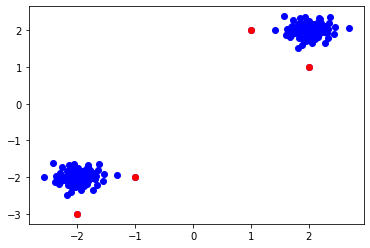

In [63]:
class Node:
    def __init__(self, val = None, right = None, left = None):
        self.val = val  
        
        # store the IDs of data points, only for leaf nodes
        self.right = right
        self.left = left

class iTree:
    def __init__(self):
        self.tree = None
        self.n_features = None

    def get_split(self, data, inds):
        
        # randomly choose (1) which feature f to split, (2) the feature split value v
        f = np.random.choice(np.arange(data.shape[1]), size = 1)
        v = np.random.uniform(min(data[inds, f]), max(data[inds,f]))
        return f, v

    def split(self, data, IDs):
        
        # split the current set of data points
        f, v = self.get_split(data, IDs)
        left_ind = []
        right_ind = []
        for i in IDs:
            if data[i, f] <= v:
                left_ind.append(i)
            else:
                right_ind.append(i)
        return left_ind, right_ind

    def buildTree(self, data, IDs):
        # leaf node
        if len(IDs) < 2:
            return Node(val = IDs)
        else:
            leftIDs, rightIDs = self.split(data, IDs)  
            left = self. buildTree(data, leftIDs)
            right = self. buildTree(data, rightIDs)
            return Node(left = left, right = right)     

        # build the non-leaf node, which recursively makes the tree deeper
        
    def fit(self, data):
        self.n_features = data.shape[1]
        IDs = np.arange(data.shape[0])
        self.tree = self.buildTree(data, IDs)
        return

    def traverse(self):
        
        # traver the tree, compute the path length
        path_len = Counter()
        i = -1

        def helper(currentNode):
            nonlocal i
            i += 1
            if currentNode.val is not None:
                for ind in currentNode.val:
                    path_len[ind] = i
                return
            for child in [currentNode.left, currentNode.right]:
                helper(child)
                i -= 1
            return

        helper(self.tree)
        return path_len


class iForest:
    def __init__(self, n_tree, ratio_outlier):
        self.n_tree = n_tree
        self.ratio_outlier = ratio_outlier  # ratio of outliers in the dataset
        self.outlierScores = Counter()

    def fit_predict(self, data):
        for _ in range(self.n_tree):
            itree = iTree()
            itree.fit(data)                 # build each iTree
            path_len = itree.traverse()     # compute path length
            self.outlierScores = self.outlierScores + path_len

        n_sample = data.shape[0]

        # compute the normalization factor c_phi
        c_phi = 2 * np.log(n_sample - 1) - (2*(n_sample - 1)/n_sample)

        for key, val in self.outlierScores.items():
            self.outlierScores[key] = 2 ** -(val / self.n_tree / c_phi)
        q = np.quantile(list(self.outlierScores.values()), 1 - self.ratio_outlier)
        outliers = [key for key, val in self.outlierScores.items() if val > q]
        return outliers


if __name__ == '__main__':
    with open('/Users/wushuangyan/Desktop/STAT classes/Linear models/data_2.npy', 'rb') as f:
        X = np.load(f)

    IF = iForest(100, 0.02)
    outierIDs = IF.fit_predict(X)
    outliers = X[outierIDs]
    for oid in outierIDs:
        print("Outliers:", X[oid])

    plt.scatter(X[:, 0], X[:, 1], color = 'b')
    plt.scatter(outliers[:, 0], outliers[:, 1], color = 'r')
    plt.show()